## Fit single Model to variogram points

In [2]:
%load_ext autoreload
%autoreload 2

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

 - generate 1D variogram and fit a single Gaussian model to it
 - fit multiple Gaussian to 1D model
 - try with higher dimensions

 $\gamma = b + c_0 * (1-e^{\frac{h^2}{a^2}})$
 where
 $a= \frac{r}{2}$

Note: To use `scipy.optimize.curve_fit()` good initial parameters are important AND data should be standardized

parameters: [11.2398343   0.73561485  0.21193905]


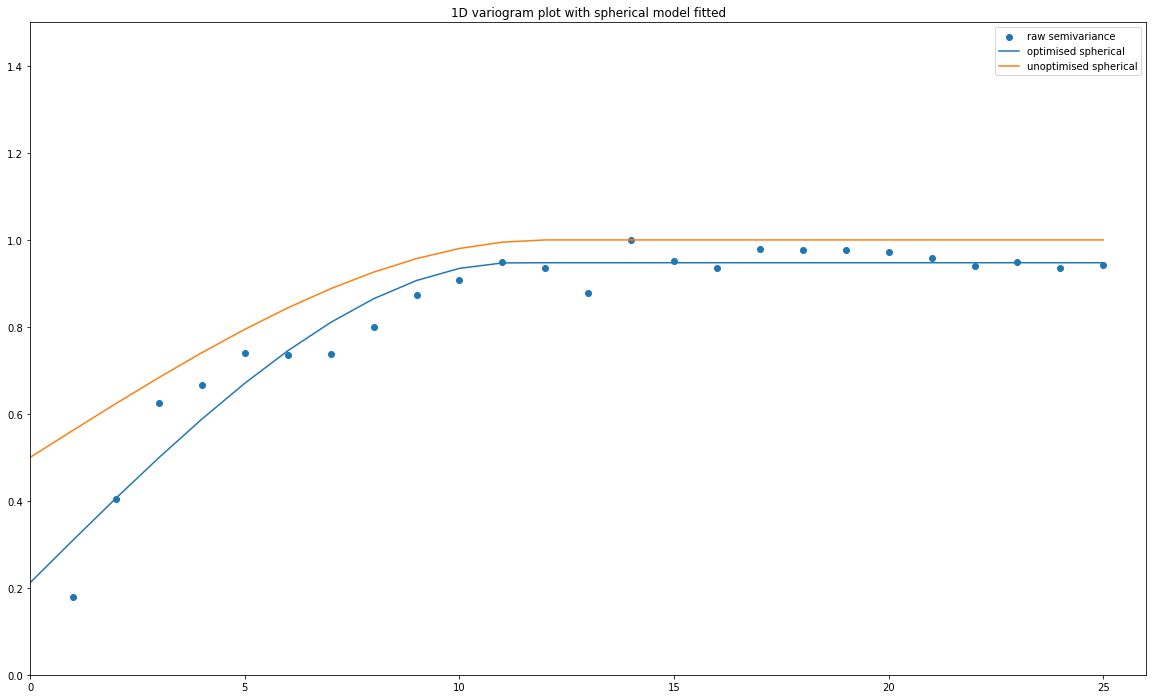

In [3]:
# define gaussian func which returns gamma
def gaussian(h, r, c0, b=0):
    """returns semivariance"""
    a = r / 2
    return b + c0 * (1. - np.exp(- (h ** 2 / a ** 2)))

def spherical(h, r, c0, b=0):
    a = r / 1.
    if hasattr(h, "__iter__"):
        output = np.empty(len(h))
        for i in range(len(output)):     
            if h[i] <= r:
                output[i] = b + c0 * ((1.5 * (h[i] / a)) - (0.5 * ((h[i] / a) ** 3.0)))
            else:
                output[i] = b + c0  
        return output 
    else:
        if h <= r:
            return b + c0 * ((1.5 * (h / a)) - (0.5 * ((h / a) ** 3.0)))
        else:
            return b + c0     

def exponential(h, r, c0, b=0):
    a = r / 3.
    return b + c0 * (1. - np.exp(-(h / a)))

def visualise_fit(func, resolution, *params):
    # inference with tuned model
    predictions_optimised = []
    for lag in range(resolution):
        predictions_optimised.append(func(lag, *params))

    # visualise the functions
    fig = plt.figure(figsize=(20,12))
    plt.scatter(data["lag"], data["semivariance"], label="raw semivariance")
    plt.plot(range(resolution), predictions_optimised, label=f"optimised {func.__name__}")
    plt.ylim([0,1.5])
    plt.xlim([0, resolution])
    plt.title(f"1D variogram plot with {func.__name__} model fitted")
    # plt.legend()
    return fig.gca()

# read in data
data = pd.read_csv("/home/jonas/Downloads/variogram_pts.csv")

# predict with tuned model
model = spherical
resolution = data["lag"].iloc[-1] + 1
popt, pcov = scipy.optimize.curve_fit(model, data["lag"], data["semivariance"], p0=[10,1,0])
ax = visualise_fit(model, resolution, *popt)
print(f"parameters: {popt}")

# make some sort of initial guess, one for each hyper-param of gaussian()
params = [12,0.5,0.5]
# predict with untuned model
predictions = []
for lag in range(resolution):
    predictions.append(model(lag, params[0], params[1], params[2]))
ax.plot(range(resolution), predictions, label=f"unoptimised {model.__name__}")
plt.legend()
plt.show()

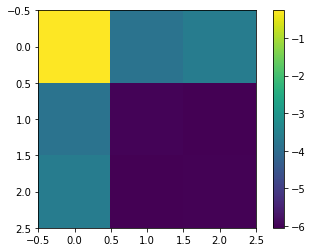

In [3]:
# show the covariance matrix
plt.imshow(np.log(np.abs(pcov)))
plt.colorbar()
plt.show()

In [ ]:
# compute metrics to evaluate fit
print(f"R^2: {r2_score(data['semivariance'], predictions_optimised[4::10])}")
print(f"mean squared error: {mean_squared_error(data['semivariance'], predictions_optimised[4::10])}")

## Fit multiple stacked models

/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


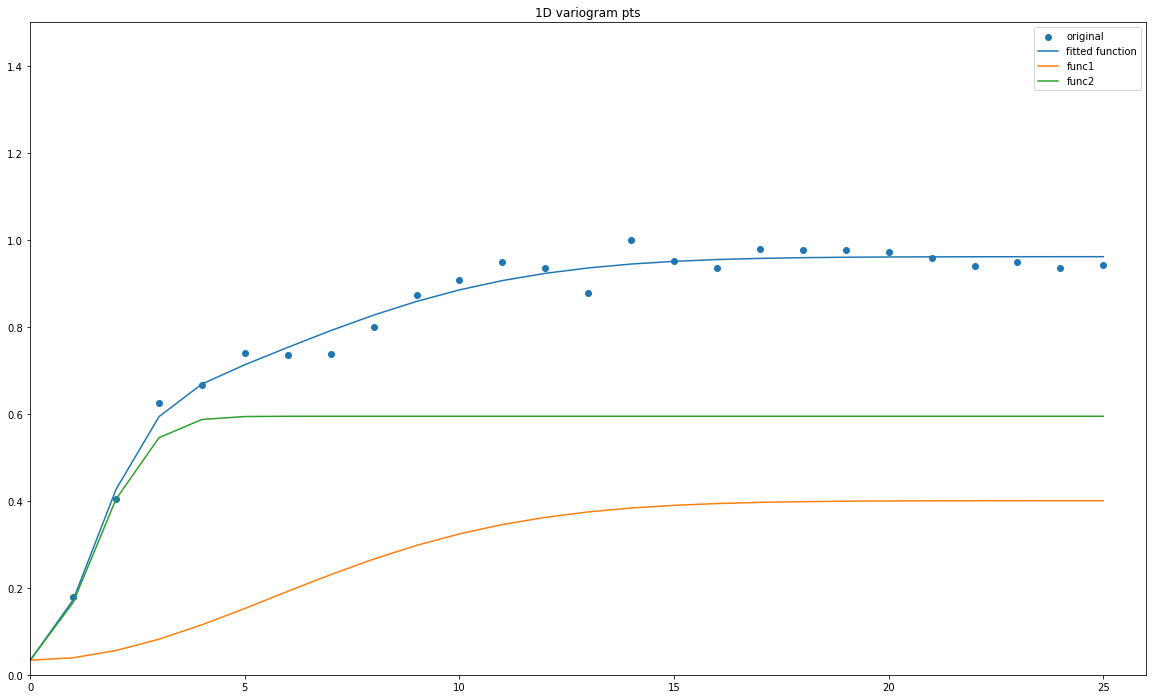

In [4]:
def stacked_gaussian(h, r1, r2, c01, c02, b1, b2):
    val1 = gaussian(h, r1, c01, b1)
    val2 = gaussian(h, r2, c02, b2)
    return val1 + val2

def plot_fitted_function(func, *params):
    predictions = []
    for lag in range(resolution):
        predictions.append(func(lag, *params))

    # visualise the functions
    fig = plt.figure(figsize=(20,12))
    plt.scatter(data["lag"], data["semivariance"], label="original")
    plt.plot(range(resolution), predictions, label="fitted function")
    plt.ylim([0,1.5])
    plt.xlim([0, resolution])
    plt.title("1D variogram pts")
    return fig.gca()
    
params_optimised, _ = scipy.optimize.curve_fit(stacked_gaussian, data["lag"], data["semivariance"])
ax = plot_fitted_function(stacked_gaussian, *params_optimised)

# plot part models
gaussian1 = np.empty(resolution)
gaussian2 = np.empty(resolution)
for i in range(resolution):
    gaussian1[i] = gaussian(i, *params_optimised[np.array([0,2,4])])
    gaussian2[i] = gaussian(i, *params_optimised[np.array([1,3,5])])
gaussian2 += params_optimised[4]
gaussian1 += params_optimised[5]
plt.plot(range(resolution), gaussian1, label="func1")
plt.plot(range(resolution), gaussian2, label="func2")
plt.legend()
plt.show()

model param names: ['r', 'c0', 'b']
independent var ['h']
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 25
    # variables        = 3
    chi-square         = 0.08321422
    reduced chi-square = 0.00378246
    Akaike info crit   = -136.630321
    Bayesian info crit = -132.973694
[[Variables]]
    r:   10.0730649 +/- 0.87030051 (8.64%) (init = 10)
    c0:  0.65069890 +/- 0.04947691 (7.60%) (init = 1)
    b:   0.29038475 +/- 0.04891962 (16.85%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.500)
    C(c0, b) = -0.951
    C(r, b)  = 0.620


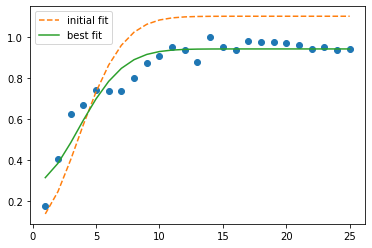

In [6]:
# use lmfit use Model to create multiple models and then stack them such as here:
# https://lmfit.github.io/lmfit-py/examples/documentation/builtinmodels_nistgauss2.html
# CompositeModel: https://lmfit.github.io/lmfit-py/model.html#composite-models-adding-or-multiplying-models

from lmfit.models import Model

# data
y = data["semivariance"]
h = data["lag"]

# define model
model = Model(gaussian)

# setup parameters
params = model.make_params(r=10,c0=1,b=0.1)
print(f"model param names: {model.param_names}")
print(f"independent var {model.independent_vars}")
result = model.fit(y, params, h=h)
print(result.fit_report(min_correl=0.5))

# plot results
plt.plot(h, y, 'o')
plt.plot(h, result.init_fit, '--', label='initial fit')
plt.plot(h, result.best_fit, '-', label='best fit')
plt.legend()
plt.show()

## Fit 3D Variogram

https://stackoverflow.com/questions/28372597/python-curve-fit-with-multiple-independent-variables

In [29]:
# Define a multi-dimensional Gaussian function (3D)
# Fit this to 3D Variogram

def multi_dim_gaussian(h_lon, h_lat, h_t, r_lon, r_lat, r_t, s):
    Omega = np.diag([1/(r_lon)**2, 1/(r_lat)**2, 1/(r_t)**2])
    h = np.array([h_lon, h_lat, h_t])
    gamma = s*(1 - np.exp(-3*np.dot(np.dot(h.T, Omega),h)))
    return gamma

# try to evaluate func
h = np.array([50,30,10])
r = np.array([500,800,20])
s = 1
print(multi_dim_gaussian(*h, *r, s))

# TODO: get good 3D empirical variogram -> perform 3D fit -> write NoiseField function -> sample from noise

0.5435238154643982
